In [1]:
import os
import cv2
import random
import imutils
import argparse 
from glob import  glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import pickle 

In [2]:
dataset_path = 'train_data/data'
dir_names = [path.split('/')[2] for path in glob(f'{dataset_path}/*')]
target_img_size = (100, 100)
sample_count = 250
print(dir_names)

['t44_hw', '8b_n', 't4', 't2', '1', 'chord', '#', 'b_hw', 't24_hw', '32', 'dot', '8_hw', '#_hw', '2', '8', '2_hw', '4_hw', 'b', 'cross', '4', 'dot_hw', '32b_r', 't24', '16b_n', 'o', '1_hw', '16_hw', '16', '16b_r', 't44', 'clef', '8b_r', '32b_n', 'o_hw']


In [3]:
def extract_raw_pixels(img):
    resized = cv2.resize(img, target_img_size)
    return resized.flatten()

In [4]:
def extract_hsv_histogram(img):
    resized = cv2.resize(img, target_img_size)
    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten()    

In [5]:
def extract_hog_features(img):
    img = cv2.resize(img, target_img_size)
    win_size = (100, 100)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [6]:
def extract_features(img, feature_set='raw'):
    if feature_set == 'hog':
        return extract_hog_features(img)
    elif feature_set == 'raw':
        return extract_raw_pixels(img)
    else:
        return extract_hsv_histogram(img)

In [7]:
def load_dataset(feature_set='raw'):
    features = []
    labels = []
    for dir_name in dir_names:
        imgs = glob(f'{dataset_path}/{dir_name}/*.png')
        subset = random.sample([i for i in range(len(imgs))], sample_count)
        for i in subset:
            img = cv2.imread(imgs[i])
            labels.append(dir_name)
            features.append(extract_features(img, feature_set))
        
    return features, labels  

In [8]:
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'NN': MLPClassifier(solver='sgd', random_state=random_seed, hidden_layer_sizes=(500,), max_iter=20, verbose=1)
}

In [9]:
def run_experiment(classifier='SVM', feature_set='raw'):
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset(feature_set)
    print('Finished loading dataset.')
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=random_seed)
    
    model = classifiers[classifier]
    print('############## Training', classifier, "##############")
    model.fit(train_features, train_labels)
    accuracy = model.score(test_features, test_labels)
    print(classifier, 'accuracy:', accuracy*100, '%')

    return model

In [10]:
model = run_experiment('KNN', 'raw') 
'''
SVM accuracy: 91.52941176470588 %
KNN accuracy: 72.88235294117648 %
NN accuracy: 85.41176470588235 %
'''

Loading dataset. This will take time ...
Finished loading dataset.
############## Training KNN ##############
KNN accuracy: 82.52941176470588 %


'\nSVM accuracy: 91.52941176470588 %\nKNN accuracy: 72.88235294117648 %\nNN accuracy: 85.41176470588235 %\n'

In [11]:
filename = 'knn_trained_model_raw.sav'
pickle.dump(model, open(filename, 'wb'))

In [12]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [13]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

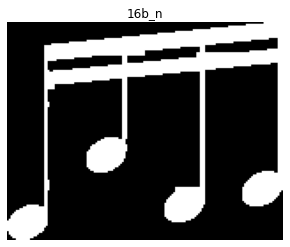

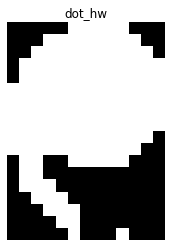

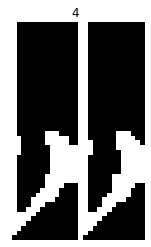

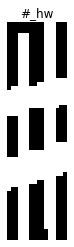

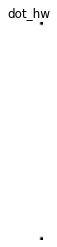

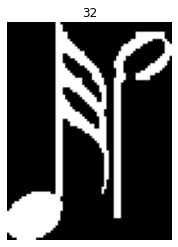

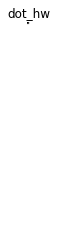

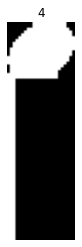

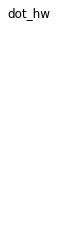

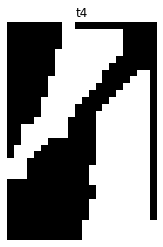

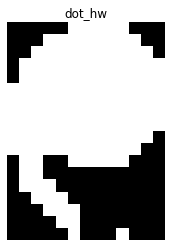

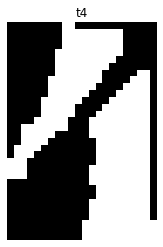

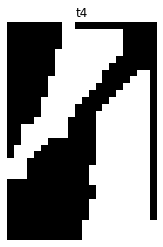

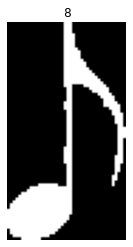

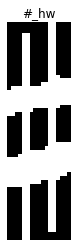

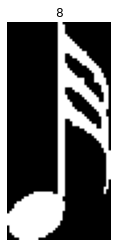

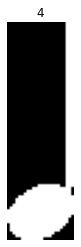

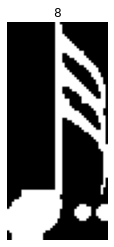

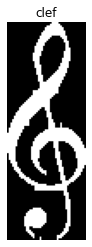

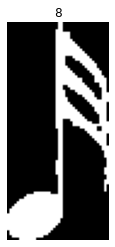

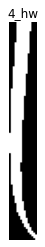

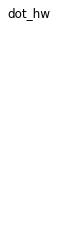

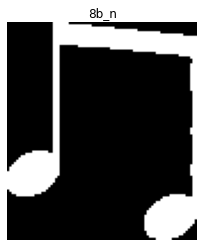

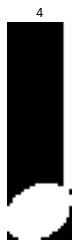

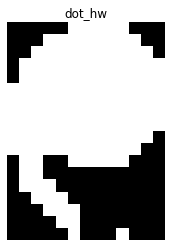

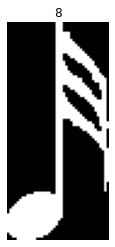

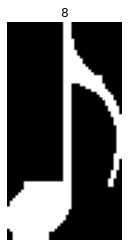

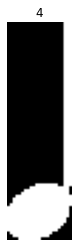

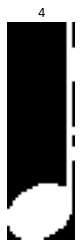

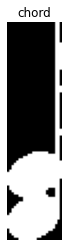

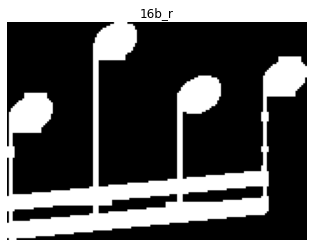

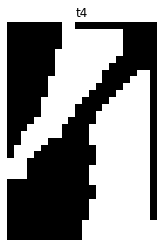

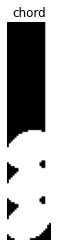

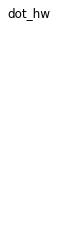

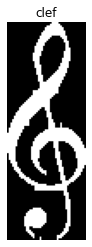

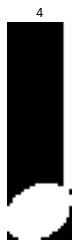

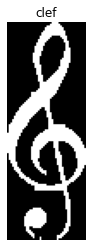

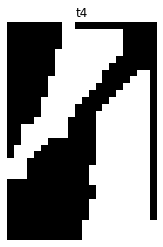

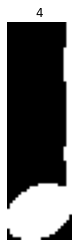

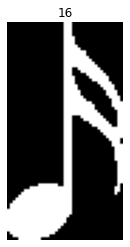

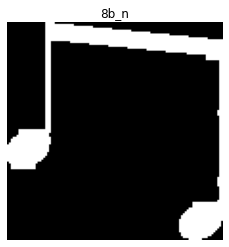

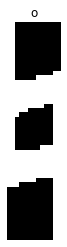

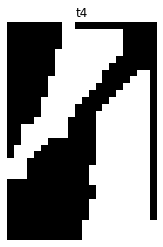

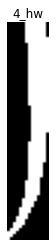

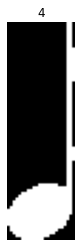

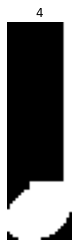

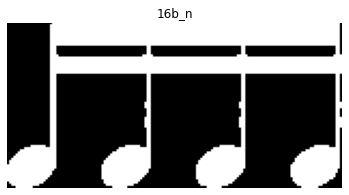

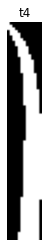

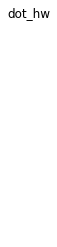

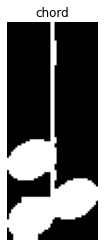

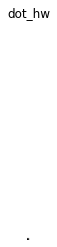

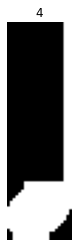

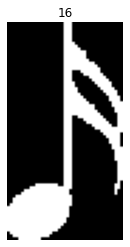

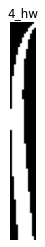

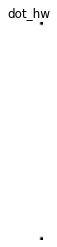

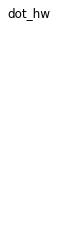

In [15]:
test_imgs = glob('testresult/*.png')
for img in test_imgs:
    img = cv2.imread(img)
    features = extract_features(img, 'raw')
    labels = model.predict([features])
    show_images([img], labels)

In [11]:
# run_experiment('hsv')
'''
SVM accuracy: 29.117647058823533 %
KNN accuracy: 56.99999999999999 %
NN accuracy: 7.588235294117647 %
'''

'\nSVM accuracy: 29.117647058823533 %\nKNN accuracy: 56.99999999999999 %\nNN accuracy: 7.588235294117647 %\n'

In [12]:
# run_experiment('raw')
'''
SVM accuracy: 80.47058823529412 %
KNN accuracy: 83.70588235294117 %
NN accuracy: 9.294117647058824 %
'''

'\nSVM accuracy: 80.47058823529412 %\nKNN accuracy: 83.70588235294117 %\nNN accuracy: 9.294117647058824 %\n'